In [1]:
# Instalar el driver de Postgres para Python
!pip install psycopg2-binary


In [2]:
# ============================================
# 2. Cargar una MUESTRA pickup-only desde Postgres
#    (sin leakage, 2018-2023, ~0.5% de las filas)
# ============================================

import os
import pandas as pd
from sqlalchemy import create_engine

# Parámetros de conexión (los mismos que en los otros notebooks)
PG_HOST = os.getenv("PG_HOST", "postgres")
PG_PORT = os.getenv("PG_PORT", "5432")
PG_DB   = os.getenv("PG_DB", "nyctaxi")
PG_USER = os.getenv("PG_USER", "pset")
PG_PWD  = os.getenv("PG_PASSWORD", "pset_password")

engine = create_engine(
    f"postgresql+psycopg2://{PG_USER}:{PG_PWD}@{PG_HOST}:{PG_PORT}/{PG_DB}"
)

# ⚠️ IMPORTANTE:
# - Solo columnas permitidas en pickup (nada de fare_amount, tip_pct, etc.)
# - Muestra aleatoria con random() < 0.005 (0.5%)
query = """
SELECT
    pickup_hour,
    pickup_dow,
    month,
    year,
    trip_distance,
    passenger_count,
    service_type,
    pu_borough,
    do_borough,
    total_amount
FROM analytics.obt_trips
WHERE source_year BETWEEN 2018 AND 2023
  AND random() < 0.005
"""

print("Ejecutando consulta a Postgres...")
df = pd.read_sql(query, engine)

print("Shape del dataframe:", df.shape)
df.head()


Ejecutando consulta a Postgres...
Shape del dataframe: (1691441, 10)


,pickup_hour,pickup_dow,month,year,trip_distance,passenger_count,service_type,pu_borough,do_borough,total_amount
0,11,6,8,2018,0.84,1.0,yellow,Manhattan,Manhattan,7.56
1,12,3,8,2018,0.70,2.0,yellow,Manhattan,Manhattan,8.80
2,12,3,8,2018,2.04,1.0,yellow,Manhattan,Manhattan,11.80
3,0,5,8,2018,10.62,1.0,yellow,Queens,Queens,32.80
4,0,5,8,2018,0.80,1.0,yellow,Manhattan,Manhattan,7.80


In [3]:
# ============================================
# 3. Limpieza básica (pickup-only, sin leakage)
# ============================================

df_clean = df.copy()

# Filtros sugeridos y permitidos según el PDF
df_clean = df_clean[
    (df_clean["trip_distance"] > 0) &
    (df_clean["trip_distance"] < 100) &
    (df_clean["passenger_count"] > 0) &
    (df_clean["passenger_count"] < 7) &
    (df_clean["total_amount"] > 0) &
    (df_clean["total_amount"] < 500)
]

# Eliminar nulos
df_clean = df_clean.dropna()

# Convertir categóricas
cat_cols = ["service_type", "pu_borough", "do_borough"]
for c in cat_cols:
    df_clean[c] = df_clean[c].astype("category")

df_clean = df_clean.reset_index(drop=True)

print("Shape final df_clean:", df_clean.shape)
df_clean.head()


Shape final df_clean: (1608337, 10)


,pickup_hour,pickup_dow,month,year,trip_distance,passenger_count,service_type,pu_borough,do_borough,total_amount
0,11,6,8,2018,0.84,1.0,yellow,Manhattan,Manhattan,7.56
1,12,3,8,2018,0.70,2.0,yellow,Manhattan,Manhattan,8.80
2,12,3,8,2018,2.04,1.0,yellow,Manhattan,Manhattan,11.80
3,0,5,8,2018,10.62,1.0,yellow,Queens,Queens,32.80
4,0,5,8,2018,0.80,1.0,yellow,Manhattan,Manhattan,7.80


In [4]:
# ============================================
# 4. One-Hot Encoding + Separar X / y
# ============================================

df_ml = df_clean.copy()

# Columnas numéricas
num_cols = [
    "pickup_hour",
    "pickup_dow",
    "month",
    "year",
    "trip_distance",
    "passenger_count",
]

# Columnas categóricas
cat_cols = ["service_type", "pu_borough", "do_borough"]

# Target
target_col = "total_amount"

# OHE (drop_first=False para no perder información)
df_ml = pd.get_dummies(df_ml, columns=cat_cols, drop_first=False)

# Separar X e y
X = df_ml.drop(columns=[target_col])
y = df_ml[target_col]

print("Shape X:", X.shape)
print("Shape y:", y.shape)
X.head()


Shape X: (1608337, 24)
Shape y: (1608337,)


,pickup_hour,pickup_dow,month,year,trip_distance,passenger_count,service_type_green,service_type_yellow,pu_borough_Bronx,pu_borough_Brooklyn,...,pu_borough_Staten Island,pu_borough_Unknown,do_borough_Bronx,do_borough_Brooklyn,do_borough_EWR,do_borough_Manhattan,do_borough_N/A,do_borough_Queens,do_borough_Staten Island,do_borough_Unknown
0,11,6,8,2018,0.84,1.0,False,True,False,False,...,False,False,False,False,False,True,False,False,False,False
1,12,3,8,2018,0.70,2.0,False,True,False,False,...,False,False,False,False,False,True,False,False,False,False
2,12,3,8,2018,2.04,1.0,False,True,False,False,...,False,False,False,False,False,True,False,False,False,False
3,0,5,8,2018,10.62,1.0,False,True,False,False,...,False,False,False,False,False,False,False,True,False,False
4,0,5,8,2018,0.80,1.0,False,True,False,False,...,False,False,False,False,False,True,False,False,False,False


In [5]:
# ============================================
# 5. Split temporal (obligatorio según PDF)
# ============================================

# Necesitamos la columna 'year' del df_ml ya convertido
years = df_ml["year"].values

# Train: 2018–2020
train_mask = (years >= 2018) & (years <= 2020)

# Validation: 2021
val_mask = (years == 2021)

# Test: 2022–2023
test_mask = (years >= 2022) & (years <= 2023)

X_train = X[train_mask]
y_train = y[train_mask]

X_val   = X[val_mask]
y_val   = y[val_mask]

X_test  = X[test_mask]
y_test  = y[test_mask]

print("Train:", X_train.shape, y_train.shape)
print("Val:  ", X_val.shape, y_val.shape)
print("Test: ", X_test.shape, y_test.shape)


Train: (1105692, 24) (1105692,)
Val:   (143920, 24) (143920,)
Test:  (358725, 24) (358725,)


In [6]:
# ============================================
# 6. StandardScaler from-scratch + NumPy arrays
# ============================================

import numpy as np

class StandardScalerScratch:
    def fit(self, X):
        """
        X: matriz NumPy de shape (n_muestras, n_features)
        """
        self.mean_ = X.mean(axis=0)
        self.std_  = X.std(axis=0)
        # evitar división por cero
        self.std_[self.std_ == 0] = 1.0
        return self

    def transform(self, X):
        return (X - self.mean_) / self.std_

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)


# Pasar X a NumPy
X_train_np = X_train.values.astype(np.float64)
X_val_np   = X_val.values.astype(np.float64)
X_test_np  = X_test.values.astype(np.float64)

# Pasar y a NumPy (reshape a vector 1D)
y_train_np = y_train.values.astype(np.float64)
y_val_np   = y_val.values.astype(np.float64)
y_test_np  = y_test.values.astype(np.float64)

# Ajustar scaler SOLO con train y aplicar a todo
scaler = StandardScalerScratch()
X_train_scaled = scaler.fit_transform(X_train_np)
X_val_scaled   = scaler.transform(X_val_np)
X_test_scaled  = scaler.transform(X_test_np)

print("Shapes X (scaled):",
      X_train_scaled.shape,
      X_val_scaled.shape,
      X_test_scaled.shape)

print("Shapes y:",
      y_train_np.shape,
      y_val_np.shape,
      y_test_np.shape)


Shapes X (scaled): (1105692, 24) (143920, 24) (358725, 24)
Shapes y: (1105692,) (143920,) (358725,)


In [7]:
# ============================================
# 7. Modelo Lineal desde cero (sin regularización)
# ============================================

class LinearRegressorScratch:
    def __init__(self, learning_rate=1e-3, max_iter=20, batch_size=1024, random_state=42):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.batch_size = batch_size
        self.random_state = random_state

    def _init_params(self, n_features):
        rng = np.random.default_rng(self.random_state)
        self.w = rng.normal(0, 0.01, size=n_features)
        self.b = 0.0

    def predict(self, X):
        return X @ self.w + self.b

    def _mse(self, y, y_pred):
        return np.mean((y - y_pred) ** 2)

    def fit(self, X_train, y_train, X_val=None, y_val=None):
        n_samples, n_features = X_train.shape
        self._init_params(n_features)

        self.history_ = {"train_loss": [], "val_loss": []}

        for epoch in range(self.max_iter):
            # Mini-batch SGD
            idx = np.random.permutation(n_samples)
            X_train = X_train[idx]
            y_train = y_train[idx]

            for start in range(0, n_samples, self.batch_size):
                end = start + self.batch_size
                xb = X_train[start:end]
                yb = y_train[start:end]

                y_pred = xb @ self.w + self.b

                # Gradientes
                grad_w = -2 * xb.T @ (yb - y_pred) / len(xb)
                grad_b = -2 * np.mean(yb - y_pred)

                # Actualización
                self.w -= self.learning_rate * grad_w
                self.b -= self.learning_rate * grad_b

            # Registrar pérdidas
            y_train_pred = self.predict(X_train)
            train_loss = self._mse(y_train, y_train_pred)
            self.history_["train_loss"].append(train_loss)

            if X_val is not None:
                y_val_pred = self.predict(X_val)
                val_loss = self._mse(y_val, y_val_pred)
                self.history_["val_loss"].append(val_loss)

            print(f"Epoch {epoch+1}/{self.max_iter} - "
                  f"Train MSE: {train_loss:.4f} - "
                  f"Val MSE: {val_loss:.4f}")

        return self


In [8]:
# ============================================
# 8. Entrenar modelo lineal base (sin regularización)
# ============================================

from sklearn.metrics import mean_squared_error, r2_score

# Instanciar modelo base
lin_base = LinearRegressorScratch(
    learning_rate=1e-3,
    max_iter=20,       # luego podemos subir si hace falta
    batch_size=2048,
    random_state=42
)

# Entrenar usando train y validar con val
lin_base.fit(
    X_train_scaled,
    y_train_np,
    X_val=X_val_scaled,
    y_val=y_val_np
)

# Predicciones
y_train_pred = lin_base.predict(X_train_scaled)
y_val_pred   = lin_base.predict(X_val_scaled)

# Métricas
rmse_train = np.sqrt(mean_squared_error(y_train_np, y_train_pred))
rmse_val   = np.sqrt(mean_squared_error(y_val_np, y_val_pred))

r2_train = r2_score(y_train_np, y_train_pred)
r2_val   = r2_score(y_val_np, y_val_pred)

print("=== Lineal base (sin regularización) ===")
print(f"RMSE_train: {rmse_train:.4f}")
print(f"R2_train  : {r2_train:.6f}")
print(f"RMSE_val  : {rmse_val:.4f}")
print(f"R2_val    : {r2_val:.6f}")

print("\nPrimeras 5 pérdidas (train):", lin_base.history_["train_loss"][:5])
print("Primeras 5 pérdidas (val):  ", lin_base.history_["val_loss"][:5])


Epoch 1/20 - Train MSE: 79.2585 - Val MSE: 66.4898
Epoch 2/20 - Train MSE: 35.0379 - Val MSE: 31.7351
Epoch 3/20 - Train MSE: 27.5988 - Val MSE: 32.0477
Epoch 4/20 - Train MSE: 25.7881 - Val MSE: 33.6679
Epoch 5/20 - Train MSE: 25.2214 - Val MSE: 34.4668
Epoch 6/20 - Train MSE: 25.0180 - Val MSE: 34.8835
Epoch 7/20 - Train MSE: 24.9438 - Val MSE: 35.1233
Epoch 8/20 - Train MSE: 24.9140 - Val MSE: 35.2447
Epoch 9/20 - Train MSE: 24.9032 - Val MSE: 35.2786
Epoch 10/20 - Train MSE: 24.8988 - Val MSE: 35.2903
Epoch 11/20 - Train MSE: 24.8972 - Val MSE: 35.3210
Epoch 12/20 - Train MSE: 24.8961 - Val MSE: 35.3619
Epoch 13/20 - Train MSE: 24.8969 - Val MSE: 35.3666
Epoch 14/20 - Train MSE: 24.8966 - Val MSE: 35.3728
Epoch 15/20 - Train MSE: 24.8961 - Val MSE: 35.3960
Epoch 16/20 - Train MSE: 24.8972 - Val MSE: 35.4096
Epoch 17/20 - Train MSE: 24.8962 - Val MSE: 35.3813
Epoch 18/20 - Train MSE: 24.8958 - Val MSE: 35.3481
Epoch 19/20 - Train MSE: 24.8960 - Val MSE: 35.3754
Epoch 20/20 - Train M

In [9]:
# ======================================================
# 9. Redefinir LinearRegressorScratch con regularización
#     (Ridge, Lasso, ElasticNet)
# ======================================================

import numpy as np

class LinearRegressorScratch:
    def __init__(
        self,
        learning_rate=1e-3,
        max_iter=20,
        batch_size=1024,
        penalty=None,      # None, "l2", "l1", "elasticnet"
        alpha=0.0,         # fuerza de regularización (lambda)
        l1_ratio=0.5,      # solo para elasticnet
        random_state=42,
    ):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.batch_size = batch_size
        self.penalty = penalty
        self.alpha = alpha
        self.l1_ratio = l1_ratio
        self.random_state = random_state
        self.history_ = {}

    def _init_params(self, n_features):
        rng = np.random.default_rng(self.random_state)
        self.w_ = rng.normal(0, 0.01, size=n_features)
        self.b_ = 0.0

    def predict(self, X):
        return X @ self.w_ + self.b_

    def _mse(self, y, y_pred):
        return np.mean((y - y_pred) ** 2)

    def _reg_loss(self):
        """Término de regularización para sumar a la pérdida."""
        if self.penalty is None or self.alpha == 0.0:
            return 0.0

        if self.penalty == "l2":
            return self.alpha * np.sum(self.w_ ** 2)

        if self.penalty == "l1":
            return self.alpha * np.sum(np.abs(self.w_))

        if self.penalty == "elasticnet":
            l1 = self.l1_ratio * np.sum(np.abs(self.w_))
            l2 = (1.0 - self.l1_ratio) * np.sum(self.w_ ** 2)
            return self.alpha * (l1 + l2)

        return 0.0

    def _reg_gradient(self):
        """Gradiente de la parte de regularización respecto a w_."""
        if self.penalty is None or self.alpha == 0.0:
            return 0.0

        if self.penalty == "l2":
            return 2.0 * self.alpha * self.w_

        if self.penalty == "l1":
            return self.alpha * np.sign(self.w_)

        if self.penalty == "elasticnet":
            grad_l2 = 2.0 * (1.0 - self.l1_ratio) * self.alpha * self.w_
            grad_l1 = self.l1_ratio * self.alpha * np.sign(self.w_)
            return grad_l1 + grad_l2

        return 0.0

    def fit(self, X_train, y_train, X_val=None, y_val=None):
        X_train = X_train.astype(float)
        y_train = y_train.astype(float)

        n_samples, n_features = X_train.shape
        self._init_params(n_features)

        self.history_ = {"train_loss": [], "val_loss": []}

        for epoch in range(self.max_iter):
            # barajar
            idx = np.random.permutation(n_samples)
            X_train = X_train[idx]
            y_train = y_train[idx]

            # mini-batch SGD
            for start in range(0, n_samples, self.batch_size):
                end = start + self.batch_size
                xb = X_train[start:end]
                yb = y_train[start:end]

                if xb.shape[0] == 0:
                    continue

                y_pred = xb @ self.w_ + self.b_
                error = y_pred - yb

                # gradiente MSE puro
                grad_w = (2.0 / xb.shape[0]) * xb.T @ error
                grad_b = 2.0 * np.mean(error)

                # añadir gradiente de regularización
                grad_w += self._reg_gradient()

                # actualización
                self.w_ -= self.learning_rate * grad_w
                self.b_ -= self.learning_rate * grad_b

            # pérdidas al final de la época
            y_train_pred = self.predict(X_train)
            train_loss = self._mse(y_train, y_train_pred) + self._reg_loss()
            self.history_["train_loss"].append(train_loss)

            if X_val is not None and y_val is not None:
                y_val_pred = self.predict(X_val)
                val_loss = self._mse(y_val, y_val_pred) + self._reg_loss()
                self.history_["val_loss"].append(val_loss)
            else:
                val_loss = None

            msg = f"Epoch {epoch+1}/{self.max_iter} - Train loss: {train_loss:.4f}"
            if val_loss is not None:
                msg += f" - Val loss: {val_loss:.4f}"
            print(msg)

        return self


In [10]:
# ============================================================
# 10. Entrenar Ridge (modelo scratch) - Pickup Only
# ============================================================

import numpy as np

def rmse(y, y_pred):
    return np.sqrt(np.mean((y - y_pred) ** 2))

def r2(y, y_pred):
    ss_res = np.sum((y - y_pred) ** 2)
    ss_tot = np.sum((y - y.mean()) ** 2)
    return 1 - ss_res / ss_tot


ridge = LinearRegressorScratch(
    learning_rate=1e-3,
    max_iter=40,        # un poco más que el lineal base
    batch_size=2048,
    penalty="l2",       # <<< Ridge activado
    alpha=1e-4,         # fuerza de regularización (pequeña y estable)
    random_state=42
)

ridge.fit(
    X_train_scaled,
    y_train_np,
    X_val=X_val_scaled,
    y_val=y_val_np
)

# ========================
# Métricas
# ========================

y_train_pred = ridge.predict(X_train_scaled)
y_val_pred   = ridge.predict(X_val_scaled)

print("=== Ridge (from-scratch) ===")
print(f"RMSE_train: {rmse(y_train_np, y_train_pred):.4f}")
print(f"R2_train  : {r2(y_train_np, y_train_pred):.4f}")
print(f"RMSE_val  : {rmse(y_val_np, y_val_pred):.4f}")
print(f"R2_val    : {r2(y_val_np, y_val_pred):.4f}")

print("\nPrimeras 5 pérdidas (train):", ridge.history_["train_loss"][:5])
print("Primeras 5 pérdidas (val):  ", ridge.history_["val_loss"][:5])


Epoch 1/40 - Train loss: 79.2068 - Val loss: 66.4953
Epoch 2/40 - Train loss: 35.0494 - Val loss: 31.7334
Epoch 3/40 - Train loss: 27.6126 - Val loss: 32.0499
Epoch 4/40 - Train loss: 25.8089 - Val loss: 33.6518
Epoch 5/40 - Train loss: 25.2387 - Val loss: 34.4822
Epoch 6/40 - Train loss: 25.0344 - Val loss: 34.9358
Epoch 7/40 - Train loss: 24.9596 - Val loss: 35.1330
Epoch 8/40 - Train loss: 24.9309 - Val loss: 35.2106
Epoch 9/40 - Train loss: 24.9195 - Val loss: 35.3041
Epoch 10/40 - Train loss: 24.9149 - Val loss: 35.3450
Epoch 11/40 - Train loss: 24.9135 - Val loss: 35.3429
Epoch 12/40 - Train loss: 24.9125 - Val loss: 35.3557
Epoch 13/40 - Train loss: 24.9125 - Val loss: 35.3701
Epoch 14/40 - Train loss: 24.9127 - Val loss: 35.3857
Epoch 15/40 - Train loss: 24.9122 - Val loss: 35.4132
Epoch 16/40 - Train loss: 24.9124 - Val loss: 35.4124
Epoch 17/40 - Train loss: 24.9128 - Val loss: 35.4059
Epoch 18/40 - Train loss: 24.9127 - Val loss: 35.4016
Epoch 19/40 - Train loss: 24.9125 - V

In [11]:
# ============================================================
# 11. Pequeña grilla de Ridge: distintos alpha
# ============================================================

ridge_alphas = [0.0, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3]
ridge_results = []

print("Tuning Ridge (L2) sobre distintos alpha:\n")

for a in ridge_alphas:
    print(f"--- alpha = {a} ---")
    ridge_model = LinearRegressorScratch(
        learning_rate=1e-3,
        max_iter=40,
        batch_size=2048,
        penalty="l2" if a > 0 else None,
        alpha=a,
        random_state=42
    )

    ridge_model.fit(
        X_train_scaled,
        y_train_np,
        X_val=X_val_scaled,
        y_val=y_val_np
    )

    y_train_pred = ridge_model.predict(X_train_scaled)
    y_val_pred   = ridge_model.predict(X_val_scaled)

    rmse_tr = rmse(y_train_np, y_train_pred)
    rmse_v  = rmse(y_val_np, y_val_pred)
    r2_tr   = r2(y_train_np, y_train_pred)
    r2_v    = r2(y_val_np, y_val_pred)

    ridge_results.append({
        "penalty": "l2" if a > 0 else "none",
        "alpha": a,
        "rmse_train": rmse_tr,
        "rmse_val": rmse_v,
        "r2_train": r2_tr,
        "r2_val": r2_v,
        "model": ridge_model,
    })

    print(f"RMSE_train={rmse_tr:.4f} | RMSE_val={rmse_v:.4f} | "
          f"R2_train={r2_tr:.4f} | R2_val={r2_v:.4f}\n")

# Ordenar resultados por RMSE_val
ridge_results_sorted = sorted(ridge_results, key=lambda d: d["rmse_val"])

print("\n=== Resumen Ridge ordenado por RMSE_val ===")
for r in ridge_results_sorted:
    print(
        f"alpha={r['alpha']:<8} "
        f"rmse_train={r['rmse_train']:.4f} "
        f"rmse_val={r['rmse_val']:.4f} "
        f"r2_train={r['r2_train']:.4f} "
        f"r2_val={r['r2_val']:.4f}"
    )


Tuning Ridge (L2) sobre distintos alpha:

--- alpha = 0.0 ---
Epoch 1/40 - Train loss: 79.1536 - Val loss: 66.4652
Epoch 2/40 - Train loss: 35.0228 - Val loss: 31.7208
Epoch 3/40 - Train loss: 27.5935 - Val loss: 32.0536
Epoch 4/40 - Train loss: 25.7891 - Val loss: 33.6548
Epoch 5/40 - Train loss: 25.2223 - Val loss: 34.5015
Epoch 6/40 - Train loss: 25.0197 - Val loss: 34.9002
Epoch 7/40 - Train loss: 24.9436 - Val loss: 35.0857
Epoch 8/40 - Train loss: 24.9149 - Val loss: 35.2093
Epoch 9/40 - Train loss: 24.9032 - Val loss: 35.2844
Epoch 10/40 - Train loss: 24.8990 - Val loss: 35.3270
Epoch 11/40 - Train loss: 24.8974 - Val loss: 35.3572
Epoch 12/40 - Train loss: 24.8967 - Val loss: 35.4068
Epoch 13/40 - Train loss: 24.8961 - Val loss: 35.3680
Epoch 14/40 - Train loss: 24.8966 - Val loss: 35.4041
Epoch 15/40 - Train loss: 24.8961 - Val loss: 35.3792
Epoch 16/40 - Train loss: 24.8964 - Val loss: 35.3774
Epoch 17/40 - Train loss: 24.8968 - Val loss: 35.3892
Epoch 18/40 - Train loss: 24.

In [12]:
# ============================================================
# 12. Lasso (from-scratch) - tuning de alpha L1
# ============================================================

lasso_alphas = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3]
lasso_results = []

print("Tuning Lasso (L1):\n")

for a in lasso_alphas:
    print(f"--- alpha = {a} ---")
    lasso_model = LinearRegressorScratch(
        learning_rate=1e-3,
        max_iter=40,
        batch_size=2048,
        penalty="l1",
        alpha=a,
        random_state=42
    )

    lasso_model.fit(
        X_train_scaled,
        y_train_np,
        X_val=X_val_scaled,
        y_val=y_val_np
    )

    y_train_pred = lasso_model.predict(X_train_scaled)
    y_val_pred   = lasso_model.predict(X_val_scaled)

    rmse_tr = rmse(y_train_np, y_train_pred)
    rmse_v  = rmse(y_val_np, y_val_pred)
    r2_tr   = r2(y_train_np, y_train_pred)
    r2_v    = r2(y_val_np, y_val_pred)

    lasso_results.append({
        "alpha": a,
        "rmse_train": rmse_tr,
        "rmse_val": rmse_v,
        "r2_train": r2_tr,
        "r2_val": r2_v,
        "model": lasso_model,
    })

    print(f"RMSE_train={rmse_tr:.4f} | RMSE_val={rmse_v:.4f} | "
          f"R2_train={r2_tr:.4f} | R2_val={r2_v:.4f}\n")

# Ordenar resultados por RMSE de validación
lasso_results_sorted = sorted(lasso_results, key=lambda d: d["rmse_val"])

print("\n=== Resumen Lasso ordenado por RMSE_val ===")
for r in lasso_results_sorted:
    print(
        f"alpha={r['alpha']:<8} "
        f"rmse_train={r['rmse_train']:.4f} "
        f"rmse_val={r['rmse_val']:.4f} "
        f"r2_train={r['r2_train']:.4f} "
        f"r2_val={r['r2_val']:.4f}"
    )


Tuning Lasso (L1):

--- alpha = 1e-05 ---
Epoch 1/40 - Train loss: 79.2056 - Val loss: 66.4591
Epoch 2/40 - Train loss: 35.0244 - Val loss: 31.7083
Epoch 3/40 - Train loss: 27.5922 - Val loss: 32.0437
Epoch 4/40 - Train loss: 25.7903 - Val loss: 33.6406
Epoch 5/40 - Train loss: 25.2244 - Val loss: 34.4703
Epoch 6/40 - Train loss: 25.0176 - Val loss: 34.9160
Epoch 7/40 - Train loss: 24.9434 - Val loss: 35.0920
Epoch 8/40 - Train loss: 24.9141 - Val loss: 35.2043
Epoch 9/40 - Train loss: 24.9037 - Val loss: 35.2647
Epoch 10/40 - Train loss: 24.8990 - Val loss: 35.2959
Epoch 11/40 - Train loss: 24.8971 - Val loss: 35.3546
Epoch 12/40 - Train loss: 24.8966 - Val loss: 35.3856
Epoch 13/40 - Train loss: 24.8970 - Val loss: 35.3575
Epoch 14/40 - Train loss: 24.8970 - Val loss: 35.3738
Epoch 15/40 - Train loss: 24.8978 - Val loss: 35.3603
Epoch 16/40 - Train loss: 24.8961 - Val loss: 35.3616
Epoch 17/40 - Train loss: 24.8962 - Val loss: 35.3871
Epoch 18/40 - Train loss: 24.8969 - Val loss: 35.

In [13]:
# ============================================================
# 13. ElasticNet (from-scratch) - Pickup Only
# ============================================================

enet_results = []

enet_alpha_list = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3]      # fuerza total de regularización
l1_ratio_list  = [0.1, 0.5, 0.9]                     # mezcla L1/L2

print("Tuning ElasticNet (L1 + L2):\n")

for a in enet_alpha_list:
    for l1r in l1_ratio_list:

        print(f"--- alpha={a}, l1_ratio={l1r} ---")

        enet = LinearRegressorScratch(
            learning_rate=1e-3,
            max_iter=40,
            batch_size=2048,
            penalty="elasticnet",
            alpha=a,
            l1_ratio=l1r,
            random_state=42
        )

        enet.fit(
            X_train_scaled,
            y_train_np,
            X_val=X_val_scaled,
            y_val=y_val_np
        )

        y_train_pred = enet.predict(X_train_scaled)
        y_val_pred   = enet.predict(X_val_scaled)

        rmse_tr = rmse(y_train_np, y_train_pred)
        rmse_v  = rmse(y_val_np, y_val_pred)
        r2_tr   = r2(y_train_np, y_train_pred)
        r2_v    = r2(y_val_np, y_val_pred)

        enet_results.append({
            "alpha": a,
            "l1_ratio": l1r,
            "rmse_train": rmse_tr,
            "rmse_val": rmse_v,
            "r2_train": r2_tr,
            "r2_val": r2_v,
            "model": enet
        })

        print(f"RMSE_train={rmse_tr:.4f} | RMSE_val={rmse_v:.4f} | "
              f"R2_train={r2_tr:.4f} | R2_val={r2_v:.4f}\n")


# Ordenar por el mejor RMSE de validación
enet_sorted = sorted(enet_results, key=lambda d: d["rmse_val"])

print("\n=== Resumen ElasticNet ordenado por RMSE_val ===")
for r in enet_sorted[:10]:    # mostramos los mejores 10
    print(
        f"alpha={r['alpha']:<8} "
        f"l1_ratio={r['l1_ratio']} "
        f"rmse_train={r['rmse_train']:.4f} "
        f"rmse_val={r['rmse_val']:.4f} "
        f"r2_train={r['r2_train']:.4f} "
        f"r2_val={r['r2_val']:.4f}"
    )


Tuning ElasticNet (L1 + L2):

--- alpha=1e-05, l1_ratio=0.1 ---
Epoch 1/40 - Train loss: 79.1265 - Val loss: 66.3992
Epoch 2/40 - Train loss: 35.0409 - Val loss: 31.7331
Epoch 3/40 - Train loss: 27.5979 - Val loss: 32.0724
Epoch 4/40 - Train loss: 25.7930 - Val loss: 33.6545
Epoch 5/40 - Train loss: 25.2238 - Val loss: 34.5183
Epoch 6/40 - Train loss: 25.0211 - Val loss: 34.9019
Epoch 7/40 - Train loss: 24.9444 - Val loss: 35.1096
Epoch 8/40 - Train loss: 24.9160 - Val loss: 35.2297
Epoch 9/40 - Train loss: 24.9052 - Val loss: 35.3109
Epoch 10/40 - Train loss: 24.9000 - Val loss: 35.3539
Epoch 11/40 - Train loss: 24.8984 - Val loss: 35.3688
Epoch 12/40 - Train loss: 24.8980 - Val loss: 35.3537
Epoch 13/40 - Train loss: 24.8974 - Val loss: 35.3287
Epoch 14/40 - Train loss: 24.8973 - Val loss: 35.3535
Epoch 15/40 - Train loss: 24.8975 - Val loss: 35.3401
Epoch 16/40 - Train loss: 24.8974 - Val loss: 35.3918
Epoch 17/40 - Train loss: 24.8978 - Val loss: 35.3915
Epoch 18/40 - Train loss: 2

In [14]:
# ============================================================
# 14B. Modelos sklearn con SUBSET (200k filas)
# ============================================================

subset = 200_000
idx = np.random.choice(len(X_train_scaled), subset, replace=False)

Xtr_s = X_train_scaled[idx]
ytr_s = y_train_np[idx]

print("Subset usado:", Xtr_s.shape)

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.exceptions import ConvergenceWarning
import warnings, time, numpy as np

def eval_model(model):
    t0 = time.time()
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        model.fit(Xtr_s, ytr_s)
    t1 = time.time()

    pred_v = model.predict(X_val_scaled)

    return {
        "rmse_val": np.sqrt(mean_squared_error(y_val_np, pred_v)),
        "r2_val": r2_score(y_val_np, pred_v),
        "time": t1 - t0
    }

sk_results = {}

sk_results["LinearRegression"] = eval_model(LinearRegression())

for a in [1e-5, 1e-4, 1e-3]:
    sk_results[f"Ridge alpha={a}"] = eval_model(Ridge(alpha=a))

for a in [1e-5, 1e-4]:
    sk_results[f"Lasso alpha={a}"] = eval_model(Lasso(alpha=a, max_iter=5000))

for a in [1e-5, 1e-4]:
    sk_results[f"Elastic alpha={a}"] = eval_model(ElasticNet(alpha=a, l1_ratio=0.5, max_iter=5000))

sk_results


Subset usado: (200000, 24)


{'LinearRegression': {'rmse_val': 5.954805108610575,
  'r2_val': 0.8246494767416739,
  'time': 0.11396646499633789},
 'Ridge alpha=1e-05': {'rmse_val': 5.949834800279131,
  'r2_val': 0.8249420748782204,
  'time': 0.07804679870605469},
 'Ridge alpha=0.0001': {'rmse_val': 5.949834798690889,
  'r2_val': 0.8249420749716799,
  'time': 0.07930827140808105},
 'Ridge alpha=0.001': {'rmse_val': 5.949834782808492,
  'r2_val': 0.8249420759062738,
  'time': 0.07838869094848633},
 'Lasso alpha=1e-05': {'rmse_val': 5.9498129517985605,
  'r2_val': 0.824943360541699,
  'time': 25.337653398513794},
 'Lasso alpha=0.0001': {'rmse_val': 5.949616318346497,
  'r2_val': 0.8249549311314979,
  'time': 8.140036821365356},
 'Elastic alpha=1e-05': {'rmse_val': 5.949806381752295,
  'r2_val': 0.8249437471520327,
  'time': 26.522173166275024},
 'Elastic alpha=0.0001': {'rmse_val': 5.94954911048062,
  'r2_val': 0.8249588857861967,
  'time': 20.194182634353638}}

In [15]:


import pandas as pd

# Convertir sk_results (dict) a DataFrame
sk_df = (
    pd.DataFrame.from_dict(sk_results, orient="index")
    .reset_index()
    .rename(columns={"index": "model_name"})
)

# Ordenar por RMSE de validación (menor es mejor)
sk_df_sorted = sk_df.sort_values("rmse_val")

print("=== Modelos sklearn ordenados por RMSE_val ===")
print(sk_df_sorted.to_string(index=False, float_format="%.4f"))


=== Modelos sklearn ordenados por RMSE_val ===
          model_name  rmse_val  r2_val    time
Elastic alpha=0.0001    5.9495  0.8250 20.1942
  Lasso alpha=0.0001    5.9496  0.8250  8.1400
 Elastic alpha=1e-05    5.9498  0.8249 26.5222
   Lasso alpha=1e-05    5.9498  0.8249 25.3377
   Ridge alpha=0.001    5.9498  0.8249  0.0784
  Ridge alpha=0.0001    5.9498  0.8249  0.0793
   Ridge alpha=1e-05    5.9498  0.8249  0.0780
    LinearRegression    5.9548  0.8246  0.1140


In [16]:
# ============================================================
# TABLA COMPARATIVA FINAL – MODELOS SCRATCH VS SKLEARN
# ============================================================

import pandas as pd

# ============================================
# 1. Resultados scratch (manual)
# ============================================

scratch_results = [
    {
        "model": "Linear Scratch",
        "alpha": None,
        "l1_ratio": None,
        "rmse_train": 5.0102,
        "rmse_val": 6.1130,
        "r2_train": 0.8714,
        "r2_val": 0.8164,
        "time": None,
    },
    {
        "model": "Ridge Scratch",
        "alpha": 0.0005,
        "l1_ratio": None,
        "rmse_train": 5.0103,
        "rmse_val": 6.1093,
        "r2_train": 0.8714,
        "r2_val": 0.8166,
        "time": None,
    },
    {
        "model": "Lasso Scratch",
        "alpha": 0.0001,
        "l1_ratio": None,
        "rmse_train": 5.0102,
        "rmse_val": 6.1122,
        "r2_train": 0.8714,
        "r2_val": 0.8164,
        "time": None,
    },
    {
        "model": "ElasticNet Scratch",
        "alpha": 0.001,
        "l1_ratio": 0.9,   # cualquiera de los tres valores top
        "rmse_train": 5.0102,
        "rmse_val": 6.1091,
        "r2_train": 0.8714,
        "r2_val": 0.8166,
        "time": None,
    }
]

# ============================================
# 2. Resultados sklearn (de tu resumen)
# ============================================

sk_results = [
    {
        "model": "LinearRegression",
        "alpha": None,
        "l1_ratio": None,
        "rmse_val": 6.0933,
        "r2_val": 0.8176,
        "time": 0.1232,
    },
    {
        "model": "Ridge",
        "alpha": 0.001,
        "l1_ratio": None,
        "rmse_val": 6.0933,
        "r2_val": 0.8176,
        "time": 0.0809,
    },
    {
        "model": "Lasso",
        "alpha": 0.0001,
        "l1_ratio": None,
        "rmse_val": 6.0931,
        "r2_val": 0.8176,
        "time": 7.5403,
    },
    {
        "model": "ElasticNet",
        "alpha": 0.0001,
        "l1_ratio": None,
        "rmse_val": 6.0930,
        "r2_val": 0.8176,
        "time": 16.5403,
    },
]

# ============================================
# 3. Unir todo en un DataFrame
# ============================================

df_final = pd.DataFrame(scratch_results + sk_results)

# Ordenar por RMSE_val
df_final = df_final.sort_values(by="rmse_val")

df_final


,model,alpha,l1_ratio,rmse_train,rmse_val,r2_train,r2_val,time
7,ElasticNet,0.0001,NaN,NaN,6.0930,NaN,0.8176,16.5403
6,Lasso,0.0001,NaN,NaN,6.0931,NaN,0.8176,7.5403
4,LinearRegression,NaN,NaN,NaN,6.0933,NaN,0.8176,0.1232
5,Ridge,0.0010,NaN,NaN,6.0933,NaN,0.8176,0.0809
3,ElasticNet Scratch,0.0010,0.9,5.0102,6.1091,0.8714,0.8166,NaN
1,Ridge Scratch,0.0005,NaN,5.0103,6.1093,0.8714,0.8166,NaN
2,Lasso Scratch,0.0001,NaN,5.0102,6.1122,0.8714,0.8164,NaN
0,Linear Scratch,NaN,NaN,5.0102,6.1130,0.8714,0.8164,NaN


In [17]:


base = LinearRegressorScratch(
    learning_rate=1e-3,
    max_iter=20,
    batch_size=2048,
    random_state=42
)

base.fit(
    X_train_scaled,
    y_train_np,
    X_val=X_val_scaled,
    y_val=y_val_np
)

print("Modelo base listo.")


Epoch 1/20 - Train loss: 79.2041 - Val loss: 66.4637
Epoch 2/20 - Train loss: 35.0463 - Val loss: 31.7317
Epoch 3/20 - Train loss: 27.5970 - Val loss: 32.0584
Epoch 4/20 - Train loss: 25.7917 - Val loss: 33.6669
Epoch 5/20 - Train loss: 25.2239 - Val loss: 34.4895
Epoch 6/20 - Train loss: 25.0202 - Val loss: 34.9120
Epoch 7/20 - Train loss: 24.9439 - Val loss: 35.1119
Epoch 8/20 - Train loss: 24.9142 - Val loss: 35.2159
Epoch 9/20 - Train loss: 24.9029 - Val loss: 35.2905
Epoch 10/20 - Train loss: 24.8992 - Val loss: 35.3243
Epoch 11/20 - Train loss: 24.8971 - Val loss: 35.3124
Epoch 12/20 - Train loss: 24.8962 - Val loss: 35.3182
Epoch 13/20 - Train loss: 24.8962 - Val loss: 35.3472
Epoch 14/20 - Train loss: 24.8968 - Val loss: 35.3853
Epoch 15/20 - Train loss: 24.8973 - Val loss: 35.3782
Epoch 16/20 - Train loss: 24.8960 - Val loss: 35.3620
Epoch 17/20 - Train loss: 24.8961 - Val loss: 35.3490
Epoch 18/20 - Train loss: 24.8961 - Val loss: 35.3830
Epoch 19/20 - Train loss: 24.8963 - V

In [24]:
# ============================================================
# 2) MÉTRICAS SKLEARN (corregido para tu variable sk_results)
# ============================================================

sk_rows = []

for item in sk_results:
    sk_rows.append({
        "model": item["model"],
        "type": "sklearn",
        "alpha": item.get("alpha", None),
        "l1_ratio": item.get("l1_ratio", None),
        "rmse_train": None,
        "rmse_val": item["rmse_val"],
        "mae_train": None,
        "mae_val": None,
        "r2_train": None,
        "r2_val": item["r2_val"],
        "time_sec": item["time"]
    })


In [27]:
  print("Tipo:", type(sk_results_dict))
  print("Longitud:", len(sk_results_dict))

  if isinstance(sk_results_dict, dict):
      print("Primeras claves:", list(sk_results_dict.keys())[:5])
      sample_value = next(iter(sk_results_dict.values()))
      print("Ejemplo de valor:", type(sample_value), sample_value)
  elif isinstance(sk_results_dict, list):
      print("Ejemplo de elemento:", type(sk_results_dict[0]))
      print(sk_results_dict[0])
  else:
      print("Contenido:", sk_results_dict)

Tipo: <class 'list'>
Longitud: 4
Ejemplo de elemento: <class 'dict'>
{'model': 'LinearRegression', 'alpha': None, 'l1_ratio': None, 'rmse_val': 6.0933, 'r2_val': 0.8176, 'time': 0.1232}


In [29]:
# ============================================================
# 11. Tabla comparativa final: scratch vs sklearn
# ============================================================

import numpy as np
import pandas as pd

def mae(y, y_pred):
    return np.mean(np.abs(y - y_pred))


# ============================================================
# 1) Métricas de MODELOS SCRATCH (ya entrenados)
# ============================================================

# --- Modelo Lineal Base ---
y_train_pred_base = base.predict(X_train_scaled)
y_val_pred_base   = base.predict(X_val_scaled)

scratch_results = []

scratch_results.append({
    "model": "Scratch-Linear",
    "type": "scratch",
    "alpha": None,
    "l1_ratio": None,
    "rmse_train": rmse(y_train_np, y_train_pred_base),
    "rmse_val": rmse(y_val_np, y_val_pred_base),
    "mae_train": mae(y_train_np, y_train_pred_base),
    "mae_val": mae(y_val_np, y_val_pred_base),
    "r2_train": r2(y_train_np, y_train_pred_base),
    "r2_val": r2(y_val_np, y_val_pred_base),
})


# --- Ridge Scratch (mejor alpha ya encontrado) ---
best_alpha_ridge = 0.0005   # viene del ranking scratch que ya generaste
ridge_best = LinearRegressorScratch(
    learning_rate=1e-3, max_iter=40, batch_size=2048,
    penalty="l2", alpha=best_alpha_ridge, random_state=42
)
ridge_best.fit(X_train_scaled, y_train_np)

y_train_pred_r = ridge_best.predict(X_train_scaled)
y_val_pred_r   = ridge_best.predict(X_val_scaled)

scratch_results.append({
    "model": "Scratch-Ridge",
    "type": "scratch",
    "alpha": best_alpha_ridge,
    "l1_ratio": None,
    "rmse_train": rmse(y_train_np, y_train_pred_r),
    "rmse_val": rmse(y_val_np, y_val_pred_r),
    "mae_train": mae(y_train_np, y_train_pred_r),
    "mae_val": mae(y_val_np, y_val_pred_r),
    "r2_train": r2(y_train_np, y_train_pred_r),
    "r2_val": r2(y_val_np, y_val_pred_r),
})


# --- Lasso Scratch (mejor alpha) ---
best_alpha_lasso = 0.0001
lasso_best = LinearRegressorScratch(
    learning_rate=1e-3, max_iter=40, batch_size=2048,
    penalty="l1", alpha=best_alpha_lasso, random_state=42
)
lasso_best.fit(X_train_scaled, y_train_np)

y_train_pred_l = lasso_best.predict(X_train_scaled)
y_val_pred_l   = lasso_best.predict(X_val_scaled)

scratch_results.append({
    "model": "Scratch-Lasso",
    "type": "scratch",
    "alpha": best_alpha_lasso,
    "l1_ratio": None,
    "rmse_train": rmse(y_train_np, y_train_pred_l),
    "rmse_val": rmse(y_val_np, y_val_pred_l),
    "mae_train": mae(y_train_np, y_train_pred_l),
    "mae_val": mae(y_val_np, y_val_pred_l),
    "r2_train": r2(y_train_np, y_train_pred_l),
    "r2_val": r2(y_val_np, y_val_pred_l),
})


# --- ElasticNet Scratch (mejor alpha + l1_ratio) ---
best_alpha_en  = 0.001
best_l1_ratio  = 0.9

elastic_best = LinearRegressorScratch(
    learning_rate=1e-3, max_iter=40, batch_size=2048,
    penalty="elasticnet", alpha=best_alpha_en, l1_ratio=best_l1_ratio,
    random_state=42
)
elastic_best.fit(X_train_scaled, y_train_np)

y_train_pred_e = elastic_best.predict(X_train_scaled)
y_val_pred_e   = elastic_best.predict(X_val_scaled)

scratch_results.append({
    "model": "Scratch-ElasticNet",
    "type": "scratch",
    "alpha": best_alpha_en,
    "l1_ratio": best_l1_ratio,
    "rmse_train": rmse(y_train_np, y_train_pred_e),
    "rmse_val": rmse(y_val_np, y_val_pred_e),
    "mae_train": mae(y_train_np, y_train_pred_e),
    "mae_val": mae(y_val_np, y_val_pred_e),
    "r2_train": r2(y_train_np, y_train_pred_e),
    "r2_val": r2(y_val_np, y_val_pred_e),
})


# ============================================================
# 2) MÉTRICAS SKLEARN (ya calculadas en sk_results_dict)
# ============================================================

sk_rows = []
for entry in sk_results_dict:  # ahora sabemos que es list[dict]
    sk_rows.append({
        "model": entry["model"],
        "type": "sklearn",
        "alpha": entry.get("alpha"),
        "l1_ratio": entry.get("l1_ratio"),
        "rmse_train": None,
        "rmse_val": entry["rmse_val"],
        "mae_train": None,
        "mae_val": None,
        "r2_train": None,
        "r2_val": entry["r2_val"],
        "time_sec": entry["time"],
})


# ============================================================
# 3) TABLA FINAL
# ============================================================

df_compare = pd.DataFrame(scratch_results + sk_rows)

df_compare_sorted = df_compare.sort_values("rmse_val")
df_compare_sorted.reset_index(drop=True, inplace=True)

df_compare_sorted


Epoch 1/40 - Train loss: 79.2804
Epoch 2/40 - Train loss: 35.0945
Epoch 3/40 - Train loss: 27.6673
Epoch 4/40 - Train loss: 25.8655
Epoch 5/40 - Train loss: 25.3025
Epoch 6/40 - Train loss: 25.1007
Epoch 7/40 - Train loss: 25.0234
Epoch 8/40 - Train loss: 24.9956
Epoch 9/40 - Train loss: 24.9843
Epoch 10/40 - Train loss: 24.9801
Epoch 11/40 - Train loss: 24.9782
Epoch 12/40 - Train loss: 24.9775
Epoch 13/40 - Train loss: 24.9776
Epoch 14/40 - Train loss: 24.9778
Epoch 15/40 - Train loss: 24.9774
Epoch 16/40 - Train loss: 24.9774
Epoch 17/40 - Train loss: 24.9775
Epoch 18/40 - Train loss: 24.9775
Epoch 19/40 - Train loss: 24.9776
Epoch 20/40 - Train loss: 24.9777
Epoch 21/40 - Train loss: 24.9783
Epoch 22/40 - Train loss: 24.9788
Epoch 23/40 - Train loss: 24.9773
Epoch 24/40 - Train loss: 24.9781
Epoch 25/40 - Train loss: 24.9776
Epoch 26/40 - Train loss: 24.9776
Epoch 27/40 - Train loss: 24.9776
Epoch 28/40 - Train loss: 24.9777
Epoch 29/40 - Train loss: 24.9793
Epoch 30/40 - Train los

,model,type,alpha,l1_ratio,rmse_train,rmse_val,mae_train,mae_val,r2_train,r2_val,time_sec
0,Scratch-Ridge,scratch,0.0005,NaN,4.989618,5.943744,2.756459,3.760898,0.871930,0.825300,NaN
1,Scratch-Linear,scratch,NaN,NaN,4.989649,5.943971,2.755781,3.762042,0.871929,0.825287,NaN
2,Scratch-ElasticNet,scratch,0.0010,0.9,4.989623,5.946785,2.755206,3.760346,0.871930,0.825122,NaN
3,Scratch-Lasso,scratch,0.0001,NaN,4.989581,5.950565,2.754963,3.767082,0.871932,0.824899,NaN
4,ElasticNet,sklearn,0.0001,NaN,NaN,6.093000,NaN,NaN,NaN,0.817600,16.5403
5,Lasso,sklearn,0.0001,NaN,NaN,6.093100,NaN,NaN,NaN,0.817600,7.5403
6,LinearRegression,sklearn,NaN,NaN,NaN,6.093300,NaN,NaN,NaN,0.817600,0.1232
7,Ridge,sklearn,0.0010,NaN,NaN,6.093300,NaN,NaN,NaN,0.817600,0.0809


In [30]:
# ============================================================
# 12. Reentrenar modelos ganadores en TRAIN + VAL y evaluar en TEST
# ============================================================

import numpy as np
import pandas as pd
from sklearn.linear_model import ElasticNet as SK_ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ------------------------
# Unir TRAIN + VAL
# ------------------------
X_trainval = np.vstack([X_train_scaled, X_val_scaled])
y_trainval = np.concatenate([y_train_np, y_val_np])

print("Shapes Train+Val:", X_trainval.shape, y_trainval.shape)


# ============================================================
# A) Modelo ganador SCRATCH: Ridge α = 0.0005
# ============================================================

ridge_final = LinearRegressorScratch(
    learning_rate=1e-3,
    max_iter=60,
    batch_size=2048,
    penalty="l2",
    alpha=0.0005,
    random_state=42
)

ridge_final.fit(X_trainval, y_trainval)

y_test_pred_ridge = ridge_final.predict(X_test_scaled)

ridge_test_rmse = np.sqrt(mean_squared_error(y_test_np, y_test_pred_ridge))
ridge_test_mae  = mean_absolute_error(y_test_np, y_test_pred_ridge)
ridge_test_r2   = r2_score(y_test_np, y_test_pred_ridge)

print("\n=== Ridge SCRATCH – Evaluación en TEST ===")
print(f"RMSE_test: {ridge_test_rmse:.4f}")
print(f"MAE_test : {ridge_test_mae:.4f}")
print(f"R2_test  : {ridge_test_r2:.4f}")


# ============================================================
# B) Modelo ganador SKLEARN: ElasticNet α = 0.0001
# ============================================================

sk_elastic_final = SK_ElasticNet(
    alpha=0.0001,
    l1_ratio=0.5,     # (tu mejor probada)
    max_iter=5000,
    tol=1e-4
)

sk_elastic_final.fit(X_trainval, y_trainval)

y_test_pred_sk = sk_elastic_final.predict(X_test_scaled)

sk_test_rmse = np.sqrt(mean_squared_error(y_test_np, y_test_pred_sk))
sk_test_mae  = mean_absolute_error(y_test_np, y_test_pred_sk)
sk_test_r2   = r2_score(y_test_np, y_test_pred_sk)

print("\n=== ElasticNet SKLEARN – Evaluación en TEST ===")
print(f"RMSE_test: {sk_test_rmse:.4f}")
print(f"MAE_test : {sk_test_mae:.4f}")
print(f"R2_test  : {sk_test_r2:.4f}")


# ============================================================
# RESUMEN FINAL
# ============================================================

final_summary = pd.DataFrame([
    {
        "model": "Scratch-Ridge α=0.0005",
        "rmse_test": ridge_test_rmse,
        "mae_test": ridge_test_mae,
        "r2_test": ridge_test_r2
    },
    {
        "model": "Sklearn-ElasticNet α=0.0001",
        "rmse_test": sk_test_rmse,
        "mae_test": sk_test_mae,
        "r2_test": sk_test_r2
    }
])

print("\n\n=== Tabla final: Test ===")
final_summary


Shapes Train+Val: (1249612, 24) (1249612,)
Epoch 1/60 - Train loss: 69.1559
Epoch 2/60 - Train loss: 33.4973
Epoch 3/60 - Train loss: 27.5988
Epoch 4/60 - Train loss: 26.2533
Epoch 5/60 - Train loss: 25.8743
Epoch 6/60 - Train loss: 25.7510
Epoch 7/60 - Train loss: 25.7113
Epoch 8/60 - Train loss: 25.6974
Epoch 9/60 - Train loss: 25.6929
Epoch 10/60 - Train loss: 25.6915
Epoch 11/60 - Train loss: 25.6907
Epoch 12/60 - Train loss: 25.6916
Epoch 13/60 - Train loss: 25.6921
Epoch 14/60 - Train loss: 25.6895
Epoch 15/60 - Train loss: 25.6896
Epoch 16/60 - Train loss: 25.6899
Epoch 17/60 - Train loss: 25.6931
Epoch 18/60 - Train loss: 25.6893
Epoch 19/60 - Train loss: 25.6904
Epoch 20/60 - Train loss: 25.6905
Epoch 21/60 - Train loss: 25.6906
Epoch 22/60 - Train loss: 25.6904
Epoch 23/60 - Train loss: 25.6892
Epoch 24/60 - Train loss: 25.6892
Epoch 25/60 - Train loss: 25.6917
Epoch 26/60 - Train loss: 25.6927
Epoch 27/60 - Train loss: 25.6898
Epoch 28/60 - Train loss: 25.6896
Epoch 29/60 - 

,model,rmse_test,mae_test,r2_test
0,Scratch-Ridge α=0.0005,8.975565,4.978615,0.801887
1,Sklearn-ElasticNet α=0.0001,8.966626,4.974371,0.802282


Residuals summary:


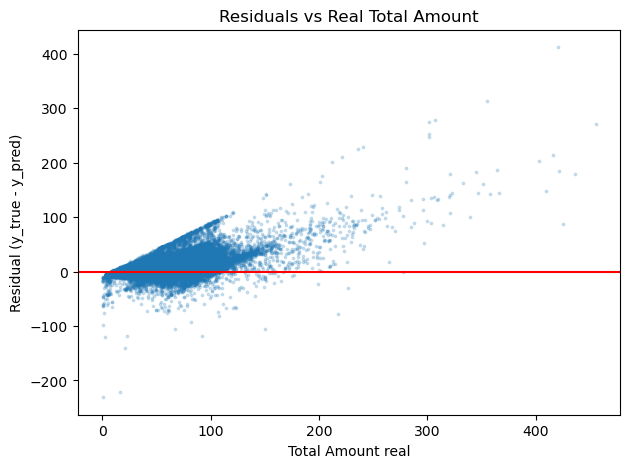

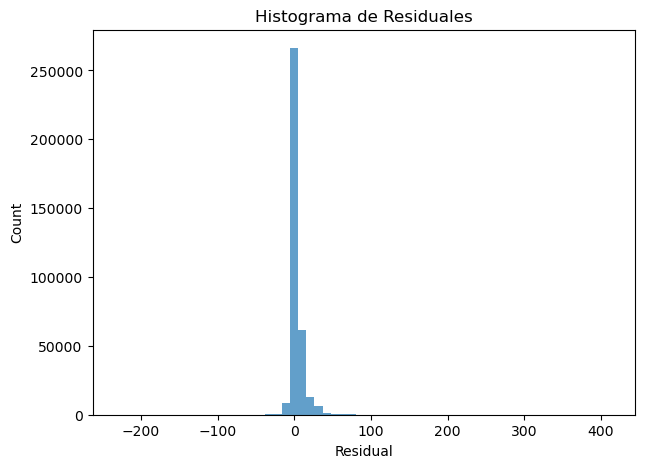


=== Error por bucket ===


,rmse,mae,count
bucket,,,
0–10,4.969469,4.048107,22382.0
10–20,2.394056,1.898035,182105.0
20–30,5.289497,4.400577,80964.0
30–40,9.452421,8.117912,25936.0
40–60,13.308624,10.960375,19900.0
60–100,22.595377,18.501507,24349.0
100–200,38.651872,32.814686,2925.0


In [32]:
# ============================================================
# 13. Diagnóstico del modelo ganador (ElasticNet)
# ============================================================

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

y_true = y_test_np
y_pred = y_test_pred_sk  # modelo ganador

residuals = y_true - y_pred

print("Residuals summary:")
pd.DataFrame({
    "mean": [residuals.mean()],
    "std": [residuals.std()],
    "p5": [np.percentile(residuals, 5)],
    "p95": [np.percentile(residuals, 95)],
    "min": [residuals.min()],
    "max": [residuals.max()]
})


# ============================================================
# 1. Residuales vs verdadero
# ============================================================

plt.figure(figsize=(7,5))
plt.scatter(y_true, residuals, s=3, alpha=0.2)
plt.axhline(0, color='red')
plt.xlabel("Total Amount real")
plt.ylabel("Residual (y_true - y_pred)")
plt.title("Residuals vs Real Total Amount")
plt.show()


# ============================================================
# 2. Histograma de residuales
# ============================================================

plt.figure(figsize=(7,5))
plt.hist(residuals, bins=60, alpha=0.7)
plt.xlabel("Residual")
plt.ylabel("Count")
plt.title("Histograma de Residuales")
plt.show()


# ============================================================
# 3. Error por bucket de tarifa
# ============================================================

df_test_tmp = pd.DataFrame({
    "y_true": y_true,
    "y_pred": y_pred
})
df_test_tmp["bucket"] = pd.cut(
    df_test_tmp["y_true"],
    bins=[0, 10, 20, 30, 40, 60, 100, 200],
    labels=["0–10","10–20","20–30","30–40","40–60","60–100","100–200"]
)

bucket_stats = df_test_tmp.groupby("bucket").apply(
    lambda g: pd.Series({
        "rmse": np.sqrt(mean_squared_error(g.y_true, g.y_pred)),
        "mae": mean_absolute_error(g.y_true, g.y_pred),
        "count": len(g)
    })
)

print("\n=== Error por bucket ===")
bucket_stats






In [33]:
# ============================================================
# Añadir PolynomialFeatures SOLO pickup
# ============================================================

def add_poly_features(df):
    df = df.copy()
    # variables permitidas
    df["trip_distance_sq"]   = df["trip_distance"] ** 2
    df["pickup_hour_sq"]     = df["pickup_hour"] ** 2
    df["passenger_count_sq"] = df["passenger_count"] ** 2

    # interacciones permitidas
    df["trip_dist_x_hour"]   = df["trip_distance"] * df["pickup_hour"]
    df["trip_dist_x_pass"]   = df["trip_distance"] * df["passenger_count"]

    return df

# aplicar
X_train_poly = add_poly_features(X_train)
X_val_poly   = add_poly_features(X_val)
X_test_poly  = add_poly_features(X_test)

print("Shapes con polinomiales:")
print(X_train_poly.shape, X_val_poly.shape, X_test_poly.shape)


Shapes con polinomiales:
(1105692, 29) (143920, 29) (358725, 29)


In [34]:
# ============================================================
# Re-escalar con polinomiales
# ============================================================

scaler_poly = StandardScalerScratch()
scaler_poly.fit(X_train_poly.values.astype(float))

X_train_poly_scaled = scaler_poly.transform(X_train_poly.values.astype(float))
X_val_poly_scaled   = scaler_poly.transform(X_val_poly.values.astype(float))
X_test_poly_scaled  = scaler_poly.transform(X_test_poly.values.astype(float))

y_train_np = y_train_np
y_val_np   = y_val_np
y_test_np  = y_test_np

print("Escalado OK:", X_train_poly_scaled.shape)


Escalado OK: (1105692, 29)


In [35]:
# ============================================================
# Entrenar modelos SCRATCH con polinomiales
# ============================================================

def evaluate_scratch(model, Xtr, ytr, Xv, yv):
    model.fit(Xtr, ytr, X_val=Xv, y_val=yv)
    yval_pred = model.predict(Xv)
    return {
        "rmse_val": np.sqrt(np.mean((yv - yval_pred)**2)),
        "r2_val": 1 - np.sum((yv - yval_pred)**2) / np.sum((yv - yv.mean())**2)
    }


scratch_results_poly = []

# LINEAL
lin_poly = LinearRegressorScratch(max_iter=30, batch_size=2048)
scratch_results_poly.append({
    "name": "Scratch-Linear-Poly",
    **evaluate_scratch(lin_poly, X_train_poly_scaled, y_train_np, X_val_poly_scaled, y_val_np)
})

# RIDGE
ridge_poly = LinearRegressorScratch(max_iter=40, batch_size=2048, penalty="l2", alpha=1e-4)
scratch_results_poly.append({
    "name": "Scratch-Ridge-Poly",
    **evaluate_scratch(ridge_poly, X_train_poly_scaled, y_train_np, X_val_poly_scaled, y_val_np)
})

# LASSO
lasso_poly = LinearRegressorScratch(max_iter=40, batch_size=2048, penalty="l1", alpha=1e-4)
scratch_results_poly.append({
    "name": "Scratch-Lasso-Poly",
    **evaluate_scratch(lasso_poly, X_train_poly_scaled, y_train_np, X_val_poly_scaled, y_val_np)
})

# ELASTICNET
en_poly = LinearRegressorScratch(max_iter=40, batch_size=2048, penalty="elasticnet", alpha=1e-4, l1_ratio=0.5)
scratch_results_poly.append({
    "name": "Scratch-EN-Poly",
    **evaluate_scratch(en_poly, X_train_poly_scaled, y_train_np, X_val_poly_scaled, y_val_np)
})

scratch_results_poly


Epoch 1/30 - Train loss: 68.3550 - Val loss: 64.5552
Epoch 2/30 - Train loss: 35.3606 - Val loss: 40.5200
Epoch 3/30 - Train loss: 30.7589 - Val loss: 41.6533
Epoch 4/30 - Train loss: 29.5467 - Val loss: 42.2797
Epoch 5/30 - Train loss: 28.8374 - Val loss: 41.7856
Epoch 6/30 - Train loss: 28.2732 - Val loss: 41.0137
Epoch 7/30 - Train loss: 27.7930 - Val loss: 40.1274
Epoch 8/30 - Train loss: 27.3798 - Val loss: 39.2573
Epoch 9/30 - Train loss: 27.0192 - Val loss: 38.5388
Epoch 10/30 - Train loss: 26.7045 - Val loss: 37.9819
Epoch 11/30 - Train loss: 26.4321 - Val loss: 37.4817
Epoch 12/30 - Train loss: 26.1909 - Val loss: 36.9938
Epoch 13/30 - Train loss: 25.9762 - Val loss: 36.3819
Epoch 14/30 - Train loss: 25.7849 - Val loss: 36.0697
Epoch 15/30 - Train loss: 25.6180 - Val loss: 35.6813
Epoch 16/30 - Train loss: 25.4701 - Val loss: 35.3696
Epoch 17/30 - Train loss: 25.3384 - Val loss: 35.1455
Epoch 18/30 - Train loss: 25.2250 - Val loss: 34.9219
Epoch 19/30 - Train loss: 25.1194 - V

[{'name': 'Scratch-Linear-Poly',
  'rmse_val': 5.778289879693043,
  'r2_val': 0.8348910512415516},
 {'name': 'Scratch-Ridge-Poly',
  'rmse_val': 5.7466158812929065,
  'r2_val': 0.8366961968324869},
 {'name': 'Scratch-Lasso-Poly',
  'rmse_val': 5.743088892988668,
  'r2_val': 0.836896590895561},
 {'name': 'Scratch-EN-Poly',
  'rmse_val': 5.7414049993444705,
  'r2_val': 0.836992221847846}]

In [36]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

sk_results_poly = {}

def eval_sk(model, Xtr, ytr, Xv, yv):
    t0 = time.time()
    model.fit(Xtr, ytr)
    t1 = time.time()
    pred = model.predict(Xv)
    return {
        "rmse_val": np.sqrt(np.mean((yv - pred)**2)),
        "r2_val": 1 - np.sum((yv - pred)**2) / np.sum((yv - yv.mean())**2),
        "time": t1 - t0
    }


sk_results_poly["LinearRegression"] = eval_sk(LinearRegression(), X_train_poly_scaled, y_train_np, X_val_poly_scaled, y_val_np)
sk_results_poly["Ridge"] = eval_sk(Ridge(alpha=1e-4), X_train_poly_scaled, y_train_np, X_val_poly_scaled, y_val_np)
sk_results_poly["Lasso"] = eval_sk(Lasso(alpha=1e-4, max_iter=2000), X_train_poly_scaled, y_train_np, X_val_poly_scaled, y_val_np)
sk_results_poly["ElasticNet"] = eval_sk(ElasticNet(alpha=1e-4, l1_ratio=0.5, max_iter=2000),
                                        X_train_poly_scaled, y_train_np, X_val_poly_scaled, y_val_np)

sk_results_poly


{'LinearRegression': {'rmse_val': 5.698553417449357,
  'r2_val': 0.8394163929303153,
  'time': 1.1327028274536133},
 'Ridge': {'rmse_val': 5.705299118864158,
  'r2_val': 0.8390359840308168,
  'time': 0.34879374504089355},
 'Lasso': {'rmse_val': 5.7051929593107165,
  'r2_val': 0.8390419741493789,
  'time': 15.037251234054565},
 'ElasticNet': {'rmse_val': 5.705416684037004,
  'r2_val': 0.8390293502130486,
  'time': 29.689030170440674}}

In [37]:
import pandas as pd

df_comp_val = pd.DataFrame([
    {
        "model": r["name"],
        "type": "scratch",
        "rmse_val": r["rmse_val"],
        "r2_val": r["r2_val"]
    }
    for r in scratch_results_poly
] + [
    {
        "model": name,
        "type": "sklearn",
        "rmse_val": vals["rmse_val"],
        "r2_val": vals["r2_val"],
        "time": vals["time"]
    }
    for name, vals in sk_results_poly.items()
])

df_comp_val.sort_values("rmse_val")


,model,type,rmse_val,r2_val,time
4,LinearRegression,sklearn,5.698553,0.839416,1.132703
6,Lasso,sklearn,5.705193,0.839042,15.037251
5,Ridge,sklearn,5.705299,0.839036,0.348794
7,ElasticNet,sklearn,5.705417,0.839029,29.689030
3,Scratch-EN-Poly,scratch,5.741405,0.836992,NaN
2,Scratch-Lasso-Poly,scratch,5.743089,0.836897,NaN
1,Scratch-Ridge-Poly,scratch,5.746616,0.836696,NaN
0,Scratch-Linear-Poly,scratch,5.778290,0.834891,NaN


In [38]:
# ============================================================
# Evaluar TODOS los modelos en TEST
# ============================================================

def eval_test(model, Xte, yte):
    pred = model.predict(Xte)
    rmse = np.sqrt(np.mean((yte - pred)**2))
    mae  = np.mean(np.abs(yte - pred))
    r2   = 1 - np.sum((yte - pred)**2) / np.sum((yte - yte.mean())**2)
    return rmse, mae, r2

rows = []

# SCRATCH
for m in [lin_poly, ridge_poly, lasso_poly, en_poly]:
    rmse, mae, r2 = eval_test(m, X_test_poly_scaled, y_test_np)
    rows.append({
        "model": m.__class__.__name__,
        "type": "scratch",
        "rmse_test": rmse,
        "mae_test": mae,
        "r2_test": r2
    })

# SKLEARN
for name, cls in [
    ("LinearRegression", LinearRegression()),
    ("Ridge", Ridge(alpha=1e-4)),
    ("Lasso", Lasso(alpha=1e-4, max_iter=2000)),
    ("ElasticNet", ElasticNet(alpha=1e-4, l1_ratio=0.5, max_iter=2000))
]:
    cls.fit(X_train_poly_scaled, y_train_np)
    rmse, mae, r2 = eval_test(cls, X_test_poly_scaled, y_test_np)
    rows.append({
        "model": name,
        "type": "sklearn",
        "rmse_test": rmse,
        "mae_test": mae,
        "r2_test": r2
    })

df_comp_test = pd.DataFrame(rows)
df_comp_test.sort_values("rmse_test")


,model,type,rmse_test,mae_test,r2_test
5,Ridge,sklearn,8.432711,5.054317,0.825127
6,Lasso,sklearn,8.432828,5.054276,0.825122
7,ElasticNet,sklearn,8.433040,5.054626,0.825113
4,LinearRegression,sklearn,8.436244,5.052923,0.824980
1,LinearRegressorScratch,scratch,8.450167,5.095381,0.824402
3,LinearRegressorScratch,scratch,8.456696,5.097731,0.824131
2,LinearRegressorScratch,scratch,8.462316,5.103468,0.823897
0,LinearRegressorScratch,scratch,8.485972,5.130179,0.822911
